# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
import nltk
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger', 'stopwords'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eks\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\eks\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\eks\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eks\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# import libraries
import pandas as pd
import numpy as np
import re
import pickle

from sqlalchemy import create_engine

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

#from sklearn.datasets import make_multilabel_classification
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.tree import DecisionTreeClassifier

In [3]:
# load data from database
engine = create_engine('sqlite:///DisasterResponse.db')
print (engine.table_names())

['Data']


In [4]:
df = pd.read_sql("SELECT * FROM Data", engine)

In [5]:
df.shape

(26023, 39)

In [6]:
# check for extra short messages
df[df['message'].str.len()<15]

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report


In [7]:
X = df['message']
Y=df.iloc[:, 4:]

In [8]:
Y.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2. Write a tokenization function to process your text data

In [9]:
# check if messages contain urls
X[X.str.contains('http')]

4996     If you want to find a Job at an NGO or the Gov...
5265     NOTES: WHAT A JERK ,ALL HAITIANS DONT HAVE ANY...
8790     Nokia.com http://ea.mobile.nokia.com/ea/graphics 
9655     BEGIN:VBKM VERSION:1.0 TITLE:Digicel Live Ha U...
9656     BEGIN:VBKM VERSION:1.0 TITLE:Item3 URL:http://...
                               ...                        
24812    USAID/OFDA fact sheets can be obtained from th...
25061    [Australian Government assistance to the Horn ...
25192    After Sall appealed to bilateral and multilate...
25515    According to the [UAE Foreign Aid Report 2011]...
25973    Meanwhile, Agritrade [ http://agritrade.cta.in...
Name: message, Length: 1092, dtype: object

In [10]:
url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

In [11]:
def tokenize(text):
    # remove urls
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")
    
    #remove punctuation
    text = re.sub(r'[^a-zA-Z09]', ' ', text)
        
    # tokenize  
    tokens = word_tokenize(text)
    
    # remove stopwords
    tokens=[w for w in tokens if w not in stopwords.words("english")]
    # lemmatize 
    lemmatizer = WordNetLemmatizer()
    clean_tokens = []
    for tok in tokens:
        # on verbs
        clean_tok = lemmatizer.lemmatize(tok, pos='v').lower().strip()
        # on nouns
        clean_tok = lemmatizer.lemmatize(clean_tok).lower().strip()
        clean_tokens.append(clean_tok)

        
    # Reduce words to their stems
    clean_tokens = [PorterStemmer().stem(w) for w in clean_tokens]

    return clean_tokens

In [12]:
sent='I wanted cup of tea from https://rty.com, but got coffie with cookies. Also cooked pancakes. I\'m happy'
tokenize(sent)

['i',
 'want',
 'cup',
 'tea',
 'urlplacehold',
 'get',
 'coffi',
 'cooki',
 'also',
 'cook',
 'pancak',
 'i',
 'happi']

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

**Random Forest Classifier**

In [13]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()), 
    ('clf', MultiOutputClassifier(RandomForestClassifier()))
    ])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(18216,) (18216, 35)
(7807,) (7807, 35)


In [15]:
pipeline.fit(X_train, y_train)

C:\Users\eks\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\eks\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\eks\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\eks\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", Fut

C:\Users\eks\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\eks\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at...
                 MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                                        class_weight=None,
                                                                        criterion='gini',
                                                                  

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [16]:
def prec_recall_report(y_true, y_pred):
    c=0
    #empty df
    scoring_results=pd.DataFrame(columns=[0, 1, 2, 3])
    for i in y_true.columns:
        prec, recall, fscore, support = precision_recall_fscore_support(y_true[i], y_pred[:,c], average='weighted')
        scoring_results=scoring_results.append(pd.DataFrame([i, prec, recall, fscore]).transpose())
        c=c+1
        
    scoring_results=scoring_results.rename(columns={0:'id', 1:'precision', 2:'recall', 3:'fscore'}). \
        reset_index(drop=True)
    f1_avg=scoring_results['fscore'].mean()
    return scoring_results

In [17]:
def f1_score_eval(y_true, y_pred):
    scoring_results=prec_recall_report(y_true, y_pred)
    return scoring_results['fscore'].mean()

In [18]:
pred=pipeline.predict(X_test)

In [19]:
randforest_results=prec_recall_report(y_test, pred)
print (randforest_results.mean())
randforest_results

precision    0.932607
recall       0.943143
fscore       0.930840
dtype: float64


C:\Users\eks\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,id,precision,recall,fscore
0,related,0.79038,0.805303,0.792762
1,request,0.879521,0.88664,0.873235
2,offer,0.990799,0.995389,0.993088
3,aid_related,0.74456,0.743435,0.736416
4,medical_help,0.903887,0.921737,0.892782
5,medical_products,0.943697,0.953247,0.935635
6,search_and_rescue,0.96318,0.971436,0.959432
7,security,0.960182,0.979762,0.969873
8,military,0.956512,0.968234,0.955041
9,water,0.95436,0.958115,0.951242


### 6. Improve your model
Use grid search to find better parameters. 

In [20]:
pipeline.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None, stop_words=None,
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=<function tokenize at 0x00000236F9389950>,
                   vocabulary=None)),
  ('tfidf',
   TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
  ('clf',
   MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                          class_weight=None,
                                                          criterion='gini',
                                                          max_depth=None,
                                                          max_fea

In [21]:
run_GridSearchCV=False
if run_GridSearchCV==True:

    parameters = {
        'clf__estimator__max_depth': [10, 20, 50],
        'clf__estimator__min_samples_leaf':[2, 5],
        'clf__estimator__criterion':['gini', 'entropy']
    }

    scorer = make_scorer(f1_score_eval)
    cv = GridSearchCV(pipeline,  param_grid=parameters, scoring = scorer)

    cv.fit(X_train, y_train)
    
    pred_tuned = cv.predict(X_test)
    gridsearch_result=prec_recall_report(y_test, pred_tuned)
    print (gridsearch_result.mean())
    print (cv.best_estimator_)
    gridsearch_result

Parameters of GridSearch.

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

**Decision Tree Classifier**

In [23]:
pipeline1 = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(DecisionTreeClassifier()))
    ])

In [24]:
pipeline1.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at...
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultiOutputClassifier(estimator=DecisionTreeClassifier(class_weight=None,
                                                                        criterion='gini',
                                                            

In [25]:
y_pred1=pipeline1.predict(X_test)

In [26]:
dectree_results=prec_recall_report(y_test, y_pred1)
print (dectree_results.mean())
dectree_results

precision    0.928875
recall       0.931431
fscore       0.930047
dtype: float64


,id,precision,recall,fscore
0,related,0.776793,0.777123,0.776957
1,request,0.847172,0.84975,0.848398
2,offer,0.99078,0.991418,0.991099
3,aid_related,0.717436,0.718586,0.717875
4,medical_help,0.894443,0.905854,0.899411
5,medical_products,0.942016,0.945818,0.943774
6,search_and_rescue,0.956628,0.962341,0.959253
7,security,0.963004,0.96644,0.964701
8,military,0.960496,0.96042,0.960458
9,water,0.954571,0.954784,0.954677


**AdaBoostClassifier**

In [27]:
from sklearn.ensemble import AdaBoostClassifier
pipeline2 = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(AdaBoostClassifier(n_estimators=100, random_state=0)))
    ])

In [28]:
pipeline2.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at 0x00000236F9389950>,
                                 vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultiOutputClassifier(estimator=AdaBoostClassifier(algorithm='SAMM

In [29]:
y_pred2=pipeline2.predict(X_test)

In [30]:
adaboost_results=prec_recall_report(y_test, y_pred2)
print (adaboost_results.mean())
adaboost_results

precision    0.937391
recall       0.945441
fscore       0.938815
dtype: float64


,id,precision,recall,fscore
0,related,0.775258,0.795312,0.76205
1,request,0.879038,0.886896,0.880278
2,offer,0.991382,0.994364,0.992776
3,aid_related,0.766334,0.76726,0.764093
4,medical_help,0.908907,0.924683,0.911163
5,medical_products,0.943382,0.953631,0.945677
6,search_and_rescue,0.96398,0.971948,0.965188
7,security,0.966479,0.978097,0.970749
8,military,0.966121,0.970924,0.967707
9,water,0.96149,0.963366,0.962214


**GridSearchCV on AdaBoostClassification**

In [31]:
run_GridSearchCV=False
if run_GridSearchCV==True:
    
    pipeline5 = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(AdaBoostClassifier(random_state=0)))
    ])

    parameters = {
        'clf__estimator__n_estimators':[100, 50]
    }

    scorer = make_scorer(f1_score_eval)
    ada_gs = GridSearchCV(pipeline5,  param_grid=parameters, scoring = scorer)

    ada_gs.fit(X_train, y_train)
    print (ada_gs.best_params_)
    
    pred_tuned = ada_gs.predict(X_test)
    gridsearch_result=prec_recall_report(y_test, pred_tuned)
    print (gridsearch_result.mean())
    gridsearch_result

- precision    0.937391
- recall       0.945441
- fscore       0.938815

best_params_={'clf__estimator__n_estimators': 100}

**Feature Union with text length**

In [32]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextLengthExtractor(BaseEstimator, TransformerMixin):

    def text_length(self, text):
        return len(text)

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.text_length)
        return pd.DataFrame(X_tagged)

In [33]:
## feature Union with length of the message

pipeline3 = Pipeline([
    ('features', FeatureUnion([
        ('text_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize)),
            ('tfidf', TfidfTransformer())
        ])),
        ('text_len', TextLengthExtractor())
        ])),
    ('clr', RandomForestClassifier())
    ])
       

In [34]:
pipeline3.fit(X_train, y_train)

C:\Users\eks\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('text_pipeline',
                                                 Pipeline(memory=None,
                                                          steps=[('vect',
                                                                  CountVectorizer(analyzer='word',
                                                                                  binary=False,
                                                                                  decode_error='strict',
                                                                                  dtype=<class 'numpy.int64'>,
                                                                                  encoding='utf-8',
                                                                                  input='content',
                                                                                  low

In [35]:
y_pred3=pipeline3.predict(X_test)

In [36]:
fu_results=prec_recall_report(y_test, y_pred3)
print (fu_results.mean())
fu_results

precision    0.928470
recall       0.939307
fscore       0.924114
dtype: float64


C:\Users\eks\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,id,precision,recall,fscore
0,related,0.809789,0.817856,0.812552
1,request,0.874545,0.882157,0.866616
2,offer,0.990799,0.995389,0.993088
3,aid_related,0.732462,0.723838,0.709145
4,medical_help,0.891579,0.918791,0.884267
5,medical_products,0.947741,0.952222,0.931363
6,search_and_rescue,0.961988,0.970795,0.956785
7,security,0.960179,0.979634,0.969809
8,military,0.958982,0.968746,0.956383
9,water,0.946757,0.949789,0.93583


**Neural Network Classification**

In [37]:
from sklearn.neural_network import MLPClassifier
nn=Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)))
    ])

nn.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at...
                                                               beta_1=0.9,
                                                               beta_2=0.999,
                                                               early_stopping=False,
                                                               epsilon=1e-08,
                    

In [38]:
y_pred4=nn.predict(X_test)
nn_results=prec_recall_report(y_test, y_pred4)
print (nn_results.mean())
nn_results

precision    0.860906
recall       0.923655
fscore       0.889439
dtype: float64


C:\Users\eks\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,id,precision,recall,fscore
0,related,0.581438,0.762521,0.65978
1,request,0.686603,0.828615,0.750954
2,offer,0.990799,0.995389,0.993088
3,aid_related,0.33922,0.582426,0.428734
4,medical_help,0.843,0.91815,0.878972
5,medical_products,0.903072,0.950301,0.926085
6,search_and_rescue,0.942195,0.970667,0.956219
7,security,0.960184,0.97989,0.969937
8,military,0.936732,0.967849,0.952037
9,water,0.877691,0.936852,0.906307


### 9. Export your model as a pickle file

Averaged F-score results:
- Random forest classification (pipeline):  0.930438
- Grid Search (on random forest) (cv): 0.912674
- Decision tree classification (pipeline1): 0.930047
- Ada Boost classification (pipeline2): 0.938815
- Random Forest with Feature Union (text length) (pipeline 3):  0.924114
- Neural Network classification (nn): 0.889439

In [39]:
filename = 'classifier.pkl'
pickle.dump(pipeline2, open(filename, 'wb'))

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

In [40]:
loaded_model = pickle.load(open('classifier.pkl', 'rb'))

In [41]:
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline 

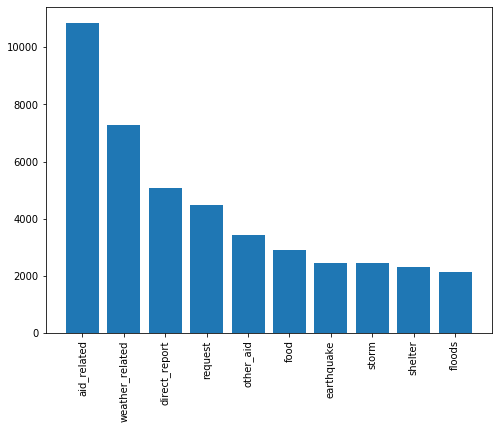

In [42]:
plt.figure(figsize=[8, 6])
top_category_count = df.iloc[:,4:].sum().sort_values(ascending=False)[1:11]
top_category_names = list(top_category_count.index)
plt.bar(top_category_names,top_category_count)
plt.xticks(rotation=90);

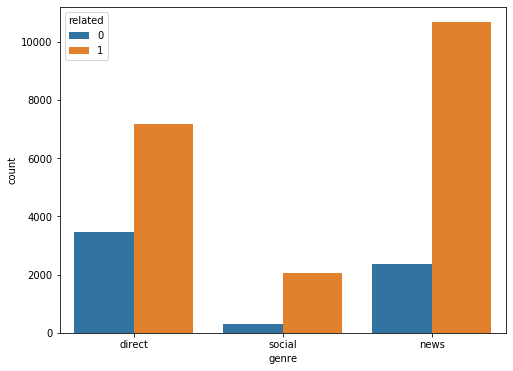

In [47]:
plt.figure(figsize=[8, 6])
sb.countplot(x="genre", hue='related', data=df)

In [48]:
aid_related1=df[df['aid_related']==1].groupby('genre').count()['message']
aid_related0=df[df['aid_related']==0].groupby('genre').count()['message']

In [49]:
aid_related1

genre
direct    4338
news      5859
social     662
Name: message, dtype: int64

In [50]:
aid_related0

genre
direct    6295
news      7173
social    1696
Name: message, dtype: int64

In [51]:
df.groupby('related').count()['message']

related
0     6120
1    19903
Name: message, dtype: int64